# Desafio Técnico — Análise de Vídeo com IA (ponta a ponta)

Este notebook apresenta uma solução ponta a ponta para o desafio de **analisar, classificar e descrever** o conteúdo de uma cena simples em vídeo. A implementação cobre **coleta**, **armazenamento** (FITS + banco local), **processamento**, **modelagem** (ML), **visualização de resultados** e **transcrição de áudio**, priorizando **reprodutibilidade**, **clareza** e **boas práticas de engenharia**.

## Sumário do Fluxo

1. **(a) Coleta e Pré‑processamento de Dados**  
   *Extrai o canal de imagem (frames a cada 0,1 s) e o canal de áudio (WAV). Define paths e dependências.*
2. **(b) Armazenamento e Tratamento de Imagens**  
   *Converte cada frame para **FITS**, anexa **metadados no header** (ex.: timestamp, índice do frame) e **persiste** no banco local (**MongoDB + GridFS**). Em seguida, **lê diretamente do banco** para validação e **plota o histograma por imagem**.*
3. **(c) Análise e Processamento de Imagens**  
   *Aplica **equalização de histograma** e compara com o original (efeito no contraste e na distribuição tonal).*
4. **(d) Classificação com Machine Learning**  
   *Realiza **rotulagem** (neste projeto, via **faixas de tempo** da gravação), **extrai features** (histogramas BGR + **GLCM**) e **treina** um classificador. Reporta **matriz de confusão** e **relatório de classificação**.*
5. **(Visualização de Resultados)**  
   *Mostra amostras de frames com o **rótulo previsto** sobreposto (e confiança, quando disponível).*
6. **(e) Análise de Áudio**  
   *Transcreve a narração (pt‑BR) com **Whisper** e apresenta o texto.*
7. **(f) Boas Práticas e Documentação**  
   *Notas sobre estrutura modular, reprodutibilidade, versionamento e próximos passos.*

---

### Pré-requisitos

- O vídeo deve estar localizado em:  
  `app/data/raw/video.mp4`

- A infraestrutura Docker + MongoDB deve estar ativa:  
  ```bash
  cd infra && make up && make notebook


## 1) Configuração do ambiente e caminhos
Define diretórios de trabalho, adiciona `app/src` ao `PYTHONPATH` e carrega as funções utilitárias da aplicação.

In [4]:
import os
import sys
import io
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Caminhos do projeto (rodando no container, /workspace é a raiz)
PROJECT_ROOT = Path("/workspace")
APP_DIR = PROJECT_ROOT / "app"
SRC_DIR = APP_DIR / "src"
DATA_DIR = APP_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
FRAMES_DIR = DATA_DIR / "frames"
FITS_DIR = DATA_DIR / "fits"
NOTEBOOK_DIR = APP_DIR / "notebook"

# Permite importar módulos de app/src
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from video_utils import extract_frames, extract_audio_ffmpeg
from image_utils import write_fits, read_fits, equalize_img, calc_histogram, to_fits_cube
from features import build_feature_vector
from db import MongoRepo
from model import train_model
from audio_utils import transcribe_wav

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("DATA_DIR:", DATA_DIR)

# Parâmetros principais
VIDEO_PATH = RAW_DIR / "video.mp4"
WAV_PATH = RAW_DIR / "audio.wav"
FRAME_INTERVAL_S = 0.1 
MONGO_URI = "mongodb://mongodb:27017"
DB_NAME = "desafio_ia"

# Garante diretórios
FRAMES_DIR.mkdir(parents=True, exist_ok=True)
FITS_DIR.mkdir(parents=True, exist_ok=True)


PROJECT_ROOT: /workspace
SRC_DIR: /workspace/app/src
DATA_DIR: /workspace/app/data


## 2) Coleta: extração de frames e áudio
A partir do vídeo original, extrai **frames** a cada 0,1 s e **áudio** em WAV mono 16 kHz. Salva frames temporários para inspeção.

In [6]:
assert VIDEO_PATH.exists(), f"Vídeo não encontrado em {VIDEO_PATH}. Coloque seu arquivo em app/data/raw/video.mp4"

# 2.1 - Extrai frames (0.1s). Salva PNGs temporários em app/data/frames/frames_tmp para debug.
frames_info = extract_frames(str(VIDEO_PATH), str(FRAMES_DIR), interval_s=FRAME_INTERVAL_S)
print(f"Frames extraídos: {len(frames_info)}")
print("Exemplo:", frames_info[:3])

# 2.2 - Extrai áudio em WAV mono 16kHz
_ = extract_audio_ffmpeg(str(VIDEO_PATH), str(WAV_PATH), sr=16000)
print("Áudio extraído para:", WAV_PATH)


Frames extraídos: 291
Exemplo: [(0, 0.0, '/workspace/app/data/frames/frames_tmp/frame_000000.png'), (6, 100.0, '/workspace/app/data/frames/frames_tmp/frame_000006.png'), (12, 200.0, '/workspace/app/data/frames/frames_tmp/frame_000012.png')]
Áudio extraído para: /workspace/app/data/raw/audio.wav


ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

## 3) Armazenamento (b): FITS + MongoDB (GridFS) com metadados
Converte cada frame para **FITS** com **metadados no header** (ex.: `FRAMEIDX`, `TS_MS`, `SOURCE`), e armazena o binário no **GridFS**, registrando metadados em coleção dedicada.

In [7]:
from astropy.io import fits

repo = MongoRepo(uri=MONGO_URI, db_name=DB_NAME)

saved_ids = []
for frame_idx, ts_ms, png_path in frames_info:
    img = cv2.imread(str(png_path))
    if img is None:
        continue

    # Metadados que também vão para o header FITS (chaves max 8 chars)
    header = {
        "frameidx": int(frame_idx),
        "ts_ms": float(ts_ms),
        "source": str(VIDEO_PATH.name)
    }

    # Monta FITS em memória (BytesIO)
    buf = io.BytesIO()
    cube = to_fits_cube(img)  # (3,H,W)
    hdu = fits.PrimaryHDU(cube)
    hdr = hdu.header
    for k, v in header.items():
        key = (str(k)[:8]).upper()
        try:
            hdr[key] = v
        except Exception:
            hdr[key] = str(v)
    hdul = fits.HDUList([hdu])
    hdul.writeto(buf, overwrite=True)
    fits_bytes = buf.getvalue()

    meta = {
        "frame_idx": int(frame_idx),
        "ts_ms": float(ts_ms),
        "filename": f"frame_{frame_idx:06d}.fits",
        "video": str(VIDEO_PATH.name)
    }
    mid = repo.save_frame(fits_bytes, meta)
    saved_ids.append(mid)

print(f"FITS salvos no MongoDB: {len(saved_ids)}")


FITS salvos no MongoDB: 291


### 3b) Leitura direta do banco e histograma por imagem
*Valida a persistência lendo os **FITS** do GridFS e calculando/plotando o **histograma** a partir das imagens recuperadas. Para evitar excesso de gráficos inline, são mostradas amostras e todos os histogramas são **salvos em disco**.*

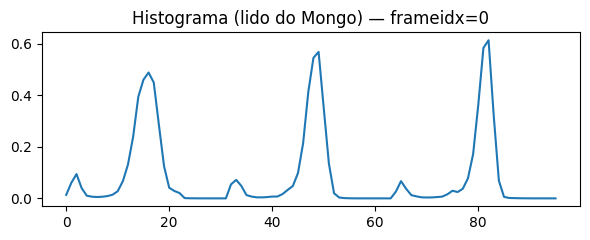

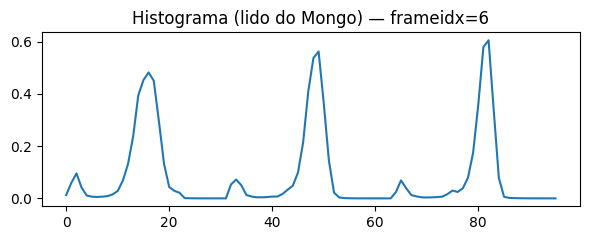

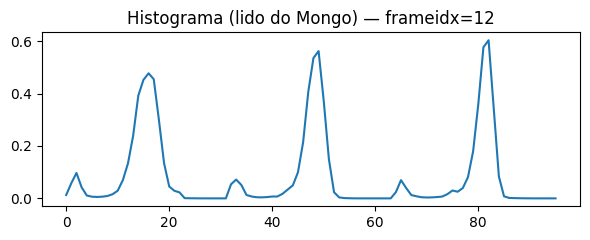

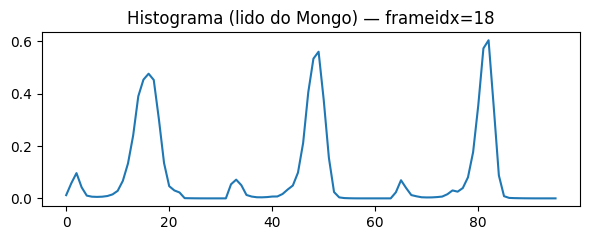

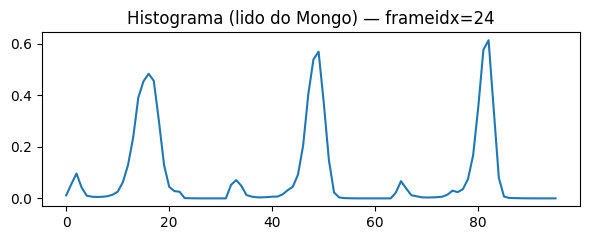

Histogramas computados a partir do Mongo: 291 (mostrados 5, salvos em /workspace/app/data/hist_from_db)


In [14]:
from io import BytesIO
from astropy.io import fits
from image_utils import from_fits_cube

# Atenção: há muitos frames; para exibir todos os gráficos no notebook ficaria impraticável.
# Vamos calcular hist para TODOS e exibir alguns, salvando os demais em disco.

hist_dir = DATA_DIR / "hist_from_db"
hist_dir.mkdir(parents=True, exist_ok=True)

all_hists = []
show_n = 5 
shown = 0

for _id in saved_ids:
    fits_bytes = repo.load_frame(_id)
    if fits_bytes is None:
        continue
    with fits.open(BytesIO(fits_bytes)) as hdul:
        cube = hdul[0].data
        hdr = dict(hdul[0].header)
    img_bgr = from_fits_cube(cube)
    h = calc_histogram(img_bgr, bins=32)
    all_hists.append(h)

    # exibe só alguns no notebook e salva todos em arquivo
    if shown < show_n:
        plt.figure(figsize=(6,2.5))
        plt.plot(h)
        plt.title(f"Histograma — frameidx={hdr.get('FRAMEIDX')}")
        plt.tight_layout()
        plt.show()
        shown += 1

    # salva a curva em PNG para reprodutibilidade
    fidx = hdr.get("FRAMEIDX", "NA")
    plt.figure()
    plt.plot(h)
    plt.title(f"Hist (Mongo) — frame {fidx}")
    out_path = hist_dir / f"hist_frame_{int(fidx) if fidx!='NA' else 0:06d}.png"
    plt.savefig(out_path)
    plt.close()

print(f"Histogramas computados a partir do Mongo: {len(all_hists)} (mostrados {show_n}, salvos em {hist_dir})")


### 4)4) Processamento (c): equalização de histograma
Aplica equalização (YCrCb/Canal Y) preservando crominância; compara **antes/depois** e suas distribuições.

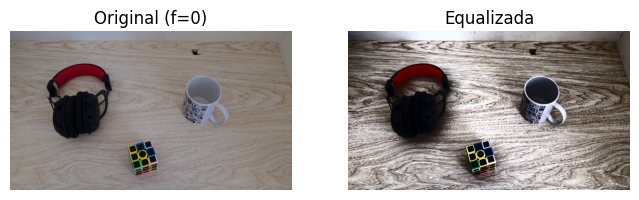

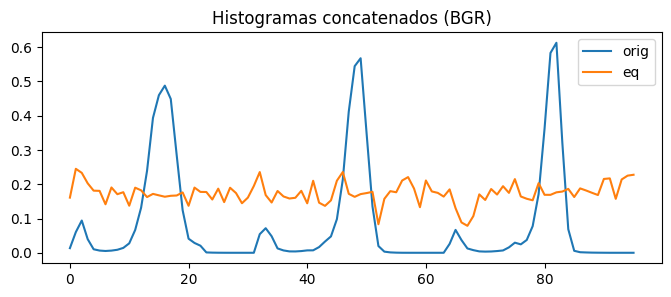

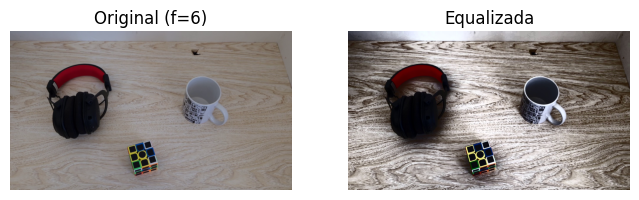

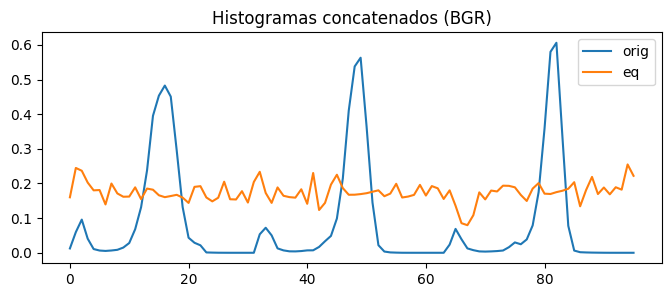

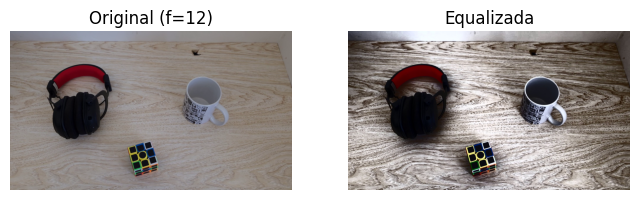

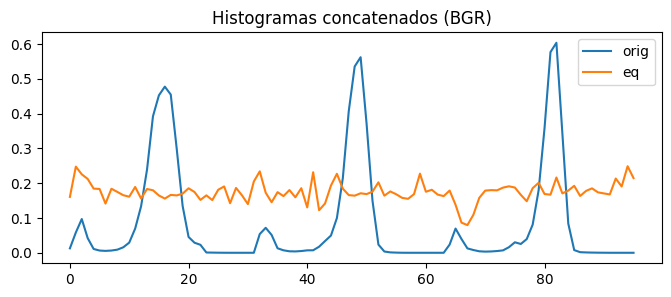

In [8]:
SAMPLE_N = min(3, len(frames_info))

for i in range(SAMPLE_N):
    fidx, ts, p = frames_info[i]
    img = cv2.imread(p)
    eq = equalize_img(img)

    # Imagens
    plt.figure(figsize=(8,3.5))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title(f"Original (f={fidx})"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(eq, cv2.COLOR_BGR2RGB)); plt.title("Equalizada"); plt.axis('off')
    plt.show()

    # Histogramas
    h_orig = calc_histogram(img, bins=32)
    h_eq = calc_histogram(eq, bins=32)

    plt.figure(figsize=(8,3))
    plt.plot(h_orig, label="orig")
    plt.plot(h_eq, label="eq")
    plt.title("Histogramas concatenados (BGR)")
    plt.legend()
    plt.show()


### 5) Rotulagem (d): faixas de tempo → labels por frame
Gera rótulos a partir das **janelas de tempo** planejadas na gravação (ex.: 11,0–14,0 s = classe 0). Opcionalmente, pular bordas de transição para evitar blur.

In [9]:
label_ranges = [
    (11.0, 14.0, 0),   # objeto A
    (16.0, 21.0, 1),  # objeto B
    (22.0, 30.0, 2),  # objeto C
]

def ts_ms_to_s(ts_ms: float) -> float:
    return ts_ms / 1000.0

labels_by_frame = {}  
for fidx, ts_ms, _ in frames_info:
    t = ts_ms_to_s(ts_ms)
    for ini, fim, cls in label_ranges:
        if ini <= t <= fim:
            labels_by_frame[fidx] = cls
            break

print("Rótulos gerados automaticamente:", len(labels_by_frame))

print(dict(list(sorted(labels_by_frame.items()))[:10]))

X, y = [], []
for fidx, ts, p in frames_info:
    if fidx not in labels_by_frame:
        continue
    img = cv2.imread(p)
    if img is None:
        continue
    eq = equalize_img(img)
    vec = build_feature_vector(eq)
    X.append(vec)
    y.append(labels_by_frame[fidx])

import numpy as np
X = np.array(X); y = np.array(y)
print("Shape X:", X.shape, "| Shape y:", y.shape)
assert X.shape[0] >= 9, "Garanta ~3–5 frames por classe para treinar."


Rótulos gerados automaticamente: 151
{660: 0, 666: 0, 672: 0, 678: 0, 684: 0, 690: 0, 696: 0, 702: 0, 708: 0, 714: 0}
Shape X: (151, 120) | Shape y: (151,)


### 6) Treinamento (d): classificador e avaliação
Treina um **RandomForest** (baseline) e reporta **classification_report** e **matriz de confusão**.

In [10]:
res = train_model(X, y, random_state=42)
print(res.report)
print("Matriz de confusão:\n", res.cm)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        18

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

Matriz de confusão:
 [[ 7  0  0]
 [ 0 13  0]
 [ 0  0 18]]


### 6a) Matriz de confusão — visual
*Exibe a matriz com rótulos legíveis (display_labels) para apresentação.*

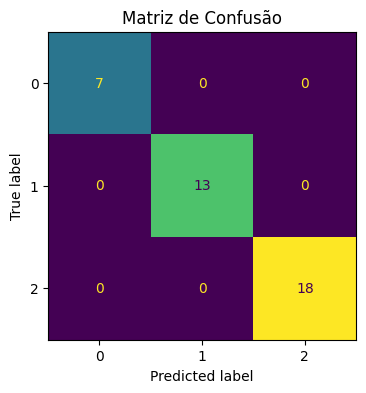

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=res.cm)
disp.plot(ax=ax, colorbar=False)
ax.set_title("Matriz de Confusão")
plt.show()


### 7) Visualização: predição por frame rotulado
Seleciona **apenas frames rotulados** (via faixas de tempo) e sobrepõe o **rótulo previsto**.

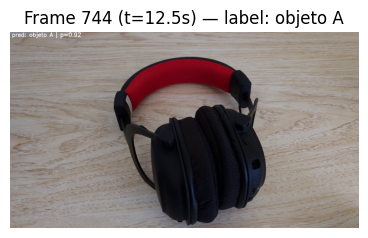

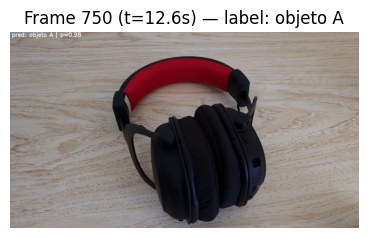

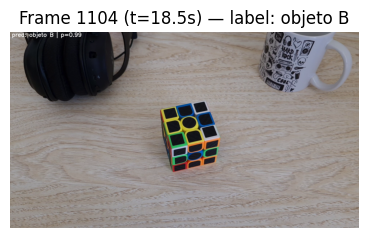

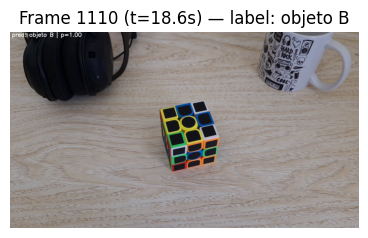

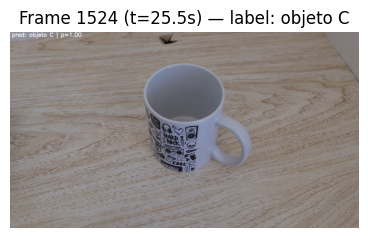

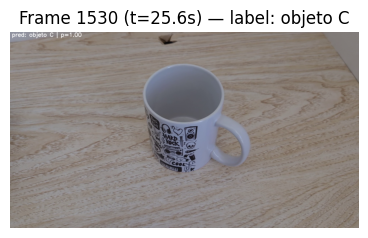

In [15]:
clf = res.clf

# Nomes amigáveis (ajuste se quiser)
class_names = {0: "objeto A", 1: "objeto B", 2: "objeto C"}

# Índice: classe -> lista de (fidx, ts, path)
by_class = {0: [], 1: [], 2: []}
for fidx, ts, p in frames_info:
    if fidx in labels_by_frame:  # só frames rotulados pelas faixas
        by_class[labels_by_frame[fidx]].append((fidx, ts, p))

# opcional: pegar frames perto do "meio" de cada faixa (mais estáveis)
def pick_mid_samples(lst, k=2):
    lst_sorted = sorted(lst, key=lambda x: x[0])
    if not lst_sorted:
        return []
    mid = len(lst_sorted) // 2
    half_k = max(1, k//2)
    lo = max(0, mid - half_k)
    hi = min(len(lst_sorted), lo + k)
    return lst_sorted[lo:hi]

samples = []
for cls, lst in by_class.items():
    samples += pick_mid_samples(lst, k=2)  # 2 por classe (ajuste à vontade)

if not samples:
    raise RuntimeError("Sem samples rotulados. Ajuste suas faixas do 5a.")

for fidx, ts, p in samples:
    img = cv2.imread(p)
    if img is None:
        continue
    eq = equalize_img(img)
    vec = build_feature_vector(eq).reshape(1, -1)
    pred = int(clf.predict(vec)[0])

    # se houver predict_proba, mostre confiança
    if hasattr(clf, "predict_proba"):
        pr = clf.predict_proba(vec)[0][pred]
        caption = f"pred: {class_names.get(pred, pred)} | p={pr:.2f}"
    else:
        caption = f"pred: {class_names.get(pred, pred)}"

    out = img.copy()
    cv2.putText(out, caption, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2, cv2.LINE_AA)

    plt.figure(figsize=(4.5, 3.5))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {fidx} (t={ts/1000:.1f}s) — label: {class_names.get(labels_by_frame[fidx], labels_by_frame[fidx])}")
    plt.axis('off')
    plt.show()


### 8) Transcrição (e): speech‑to‑text com Whisper
Transcreve o áudio capturado durante o vídeo (português).

In [13]:
assert WAV_PATH.exists(), f"WAV não encontrado em {WAV_PATH}"
texto = transcribe_wav(str(WAV_PATH), model_size="base")
print("Transcrição (preview):\n", texto)


100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 30.8MiB/s]
/usr/local/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcrição (preview):
 Sobre a mesa existem três objetos, um fone preto, um cubo mágico e uma caneca branca. O fone em preto com detalhes vermelho, o cubo mágico preto com detalhes em colorido, e uma caneca branca com desenhos pretos como detalhes.
